# Homework 4

In [1]:
import os
import numpy as np
from skimage import io, transform, feature, color
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

## Question 1

### Part A

In [2]:
caltech101 = '../../Data/main/caltech-101/101_ObjectCategories'

### Part B

Computing the average of the images and displaying the result.

1. Setting parameters.

In [3]:
excludables = ["BACKGROUND_Google", "Faces_easy", ".DS_Store"]
size = (100, 100)
grid = (10, 10)

- Initializing variables for Question 2.

In [4]:
max_images = 0
max_height = 0
max_width = 0
min_images = float('inf')
min_height = float('inf')
min_width = float('inf')

2. Computing the average of the images.

In [5]:
averages = []

for cls in sorted(os.listdir(caltech101)):
    if cls in excludables:
        continue

    clsPath = os.path.join(caltech101, cls)

    imgSum = np.zeros((size[0], size[1], 3), dtype = np.float32)
    count = 0

    for img in os.listdir(clsPath):
        imgPath = os.path.join(clsPath, img)
        image = io.imread(imgPath)

        count += 1

        height, width = image.shape[0], image.shape[1]
        
        if height > max_height:
            max_height = height
        if height < min_height:
            min_height = height
        if width > max_width:
            max_width = width
        if width < min_width:
            min_width = width

        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]

        image = transform.resize(image, size, anti_aliasing=True)
        imgSum += image

    if count > max_images:
        max_images = count
    if count < min_images:
        min_images = count

    if count > 0:
        avg = imgSum / count
        averages.append(avg)

3. Creating the collage.

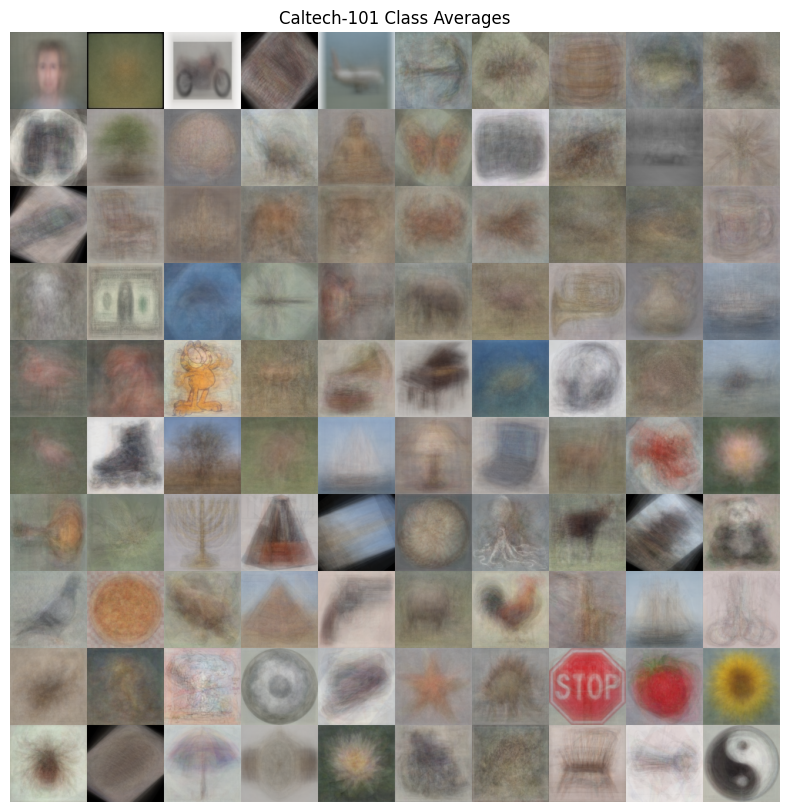

In [6]:
collage = np.zeros((grid[0] * size[0], grid[1] * size[1], 3), dtype = np.float32)

for i, avg in enumerate(averages):
    row = i // grid[1]
    col = i % grid[1]
    collage[row * size[0]:(row + 1) * size[0],
           col * size[1]:(col + 1) * size[1], :] = avg

plt.figure(figsize=(10, 10))
plt.imshow(collage)
plt.axis('off')
plt.title('Caltech-101 Class Averages')
plt.show()

## Question 2

I initiliazed max and min variables and kept updating them while iterating over the images.

Here is the result:

In [7]:
print(f'(a) The maximum number of images in a class: {max_images}')
print(f'(b) The minimum number of images in a class: {min_images}')
print(f'(c-1) The maximum height of an image: {max_height}')
print(f'(c-2) The minimum height of an image: {min_height}')
print(f'(d-1) The maximum width of an image: {max_width}')
print(f'(d-2) The minimum width of an image: {min_width}')

(a) The maximum number of images in a class: 800
(b) The minimum number of images in a class: 31
(c-1) The maximum height of an image: 494
(c-2) The minimum height of an image: 92
(d-1) The maximum width of an image: 708
(d-2) The minimum width of an image: 80


## Question 3

Let's do this step by step :)

1. Removing the two classes from the dataset

In [8]:
# filtering out the excludables
all_classes = [i for i in os.listdir(caltech101) if i not in excludables]

# display the number of classes
print(f'Total number of classes: {len(all_classes)}')

Total number of classes: 100


2. Setting Positive and Negative classes (finding the 3 largest classes)

In [9]:
# selecting positive class
pos_class = 'airplanes'

# selecting negative class (3 largest classes, excluding the positive class)
class_size = {}
for cls in all_classes:
    clsPath = os.path.join(caltech101, cls)
    class_size[cls] = len(os.listdir(clsPath))

sorted_classes = sorted(class_size.items(), key=lambda x: x[1], reverse=True)
neg_classes = [i[0] for i in sorted_classes if i[0] != pos_class][:3]

# displaying the selected classes
print(f'The positive class: {pos_class}')
print(f'The negative classes: {neg_classes}')

The positive class: airplanes
The negative classes: ['Motorbikes', 'Faces', 'watch']


3. Creating functions for Normalizing the images, and extracting HOG features.

In [ ]:
# normalizing the images
def imNormalize(image):
    if image.ndim == 2:
        image = np.stack((image, image, image), axis=2)
    
    if not np.issubdtype(image.dtype, np.floating):
        image = image.astype(np.float32)
    
    norm_channels = []
    for i in range(3):
        channel = image[:, :, i]
        channel = channel - channel.min()
        if channel.max() > 0:
            channel = channel / channel.max()
        norm_channels.append(np.uint8(channel * 255))
    
    norm_image = np.stack(norm_channels, axis=2)
    return norm_image

# extracting the HOG features
def extract_hog(image):
    gray = color.rgb2gray(image)
    features = feature.hog(gray, 
                   orientations=9, 
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   feature_vector=True)
    return features

4. I had issues with creating numpy arrays because of the sizes, so I have to resize the images.

In [ ]:
target_size = (256, 256)

# resizing all the images to the target size
def resize_image(image, target_size):
    resized = transform.resize(image, target_size, anti_aliasing=True)
    return resized

5. Making Training set.

In [ ]:
# the training sets
X_train = []
y_train = [] # Labels: 1 for airplanes, 0 for negatives

# adding positive class to train set
pos_dir = os.path.join(caltech101, pos_class)
for fname in os.listdir(pos_dir):
    fpath = os.path.join(pos_dir, fname)
    try:
        img = io.imread(fpath)
        img = resize_image(img, target_size)
    except Exception as e:
        print(f"Error processing {fpath}: {e}")
    img = imNormalize(img)
    feat = extract_hog(img)
    X_train.append(feat)
    y_train.append(1)

# adding negative classes to train set
for neg_class in neg_classes:
    neg_dir = os.path.join(caltech101, neg_class)
    for fname in os.listdir(neg_dir):
        fpath = os.path.join(neg_dir, fname)
        try:
            img = io.imread(fpath)
            img = resize_image(img, target_size)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")
        img = imNormalize(img)
        feat = extract_hog(img)
        X_train.append(feat)
        y_train.append(0)

# converting to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# displaying
print(f'Training set size: {X_train.shape[0]} samples')

Training set size: 2272 samples


6. Making Testing set.

In [ ]:
# classes other than the 4
test_classes = []

for cls in all_classes:
    if cls not in [pos_class] + neg_classes:
        test_classes.append(cls)

# adding all the images
X_test = []
test_images = []

for cls in test_classes:
    test_cls_dir = os.path.join(caltech101, cls)
    file_list = os.listdir(test_cls_dir)
    for fname in file_list:
        fpath = os.path.join(test_cls_dir, fname)
        try:
            img = io.imread(fpath)
            img = resize_image(img, target_size)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")
        img = imNormalize(img)
        feat = extract_hog(img)
        X_test.append(feat)
        test_images.append(img)

X_test = np.array(X_test)

# displaying
print(f'Test set size: {X_test.shape[0]} samples')

Test set size: 5970 samples


7. Training the SVM classifier.

In [14]:
# training the classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

8. making predictions.

In [15]:
# making predictions
predictions = clf.predict(X_test)

9. Extracting the indices classified as positive.

In [16]:
# the ones with label 1 (airplanes)
pos_indices = np.where(predictions == 1)[0]

# displaying
print("CLASSIFICATION RESULTS")
print(f'Airplane: {len(pos_indices)}')
print(f'Not Airplane: {len(predictions) - len(pos_indices)}')

CLASSIFICATION RESULTS
Airplane: 1040
Not Airplane: 4930


10. Displaying the positive images (ones classified as airplanes).

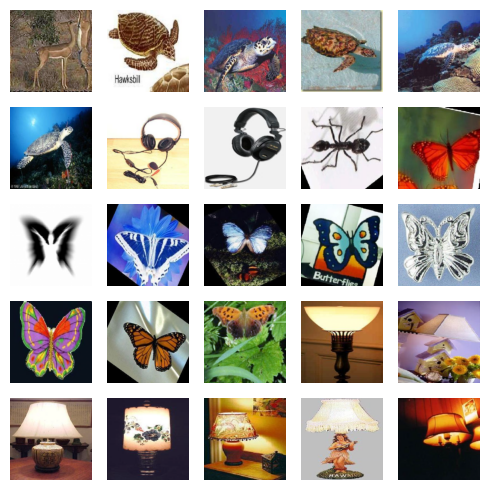

In [20]:
num_to_display = min(25, len(pos_indices))

plt.figure(figsize=(5,5))

for i in range(num_to_display):
    idx = pos_indices[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Note

The point of this classifier is NOT to show images classified as airplanes, but to show the ones that have the same HOG features as the airplanes class.